In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int




In [3]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [4]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "mdcm_pbe0dz_FOE.ff.pkl"

In [5]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FF: LJ water_cluster ELEC harmonic first_order_energy (jax_coloumb: True)

In [6]:
_c.intE = "ECOL"
_c.set_targets()
# _c.targets
# _c.data.ECOL
# _c.data.ELEC

In [7]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           # quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


Optimizing LJ parameters...
function: get_loss_chgpen
bounds: [(100, 2000), (100, 2000), (100, 2000), (100, 2000), (0, 2000)]
maxfev: 10000
initial guess: [148.13465967100572, 1369.6851741858204, 1730.6230783792223, 1734.5864952947502, 20.65580946604717]
final_loss_fn:  134.03280639648438
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 134.03280639648438
             x: [ 1.000e+02  1.005e+02  1.094e+03  1.000e+02  2.510e+02]
           nit: 129
          nfev: 337
 final_simplex: (array([[ 1.000e+02,  1.005e+02, ...,  1.000e+02,
                         2.510e+02],
                       [ 1.000e+02,  1.005e+02, ...,  1.000e+02,
                         2.510e+02],
                       ...,
                       [ 1.000e+02,  1.005e+02, ...,  1.000e+02,
                         2.510e+02],
                       [ 1.000e+02,  1.005e+02, ...,  1.000e+02,
                         2.510e+02]]), array([ 1.340e+02,  1.340e+02,

In [8]:
resx = _c.opt_parm 
loss = _c.get_loss_chgpen(resx)
loss
resx

array([ 100.        ,  100.4587105 , 1094.1523211 ,  100.        ,
        251.01471606])

In [9]:
np.sqrt(loss)

11.577254

In [10]:
# _c.eval_jax_chgpen(resx ) 

2.81158961403372e-184


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 134.03279156992917,
  'RMSE': 11.57725319624345,
  'R': 0.9024643740204571,
  'RS': 0.8883427213708854,
  'n': 500,
  'slope': 0.9600821546655568,
  'intercept': -3.456298666331179})

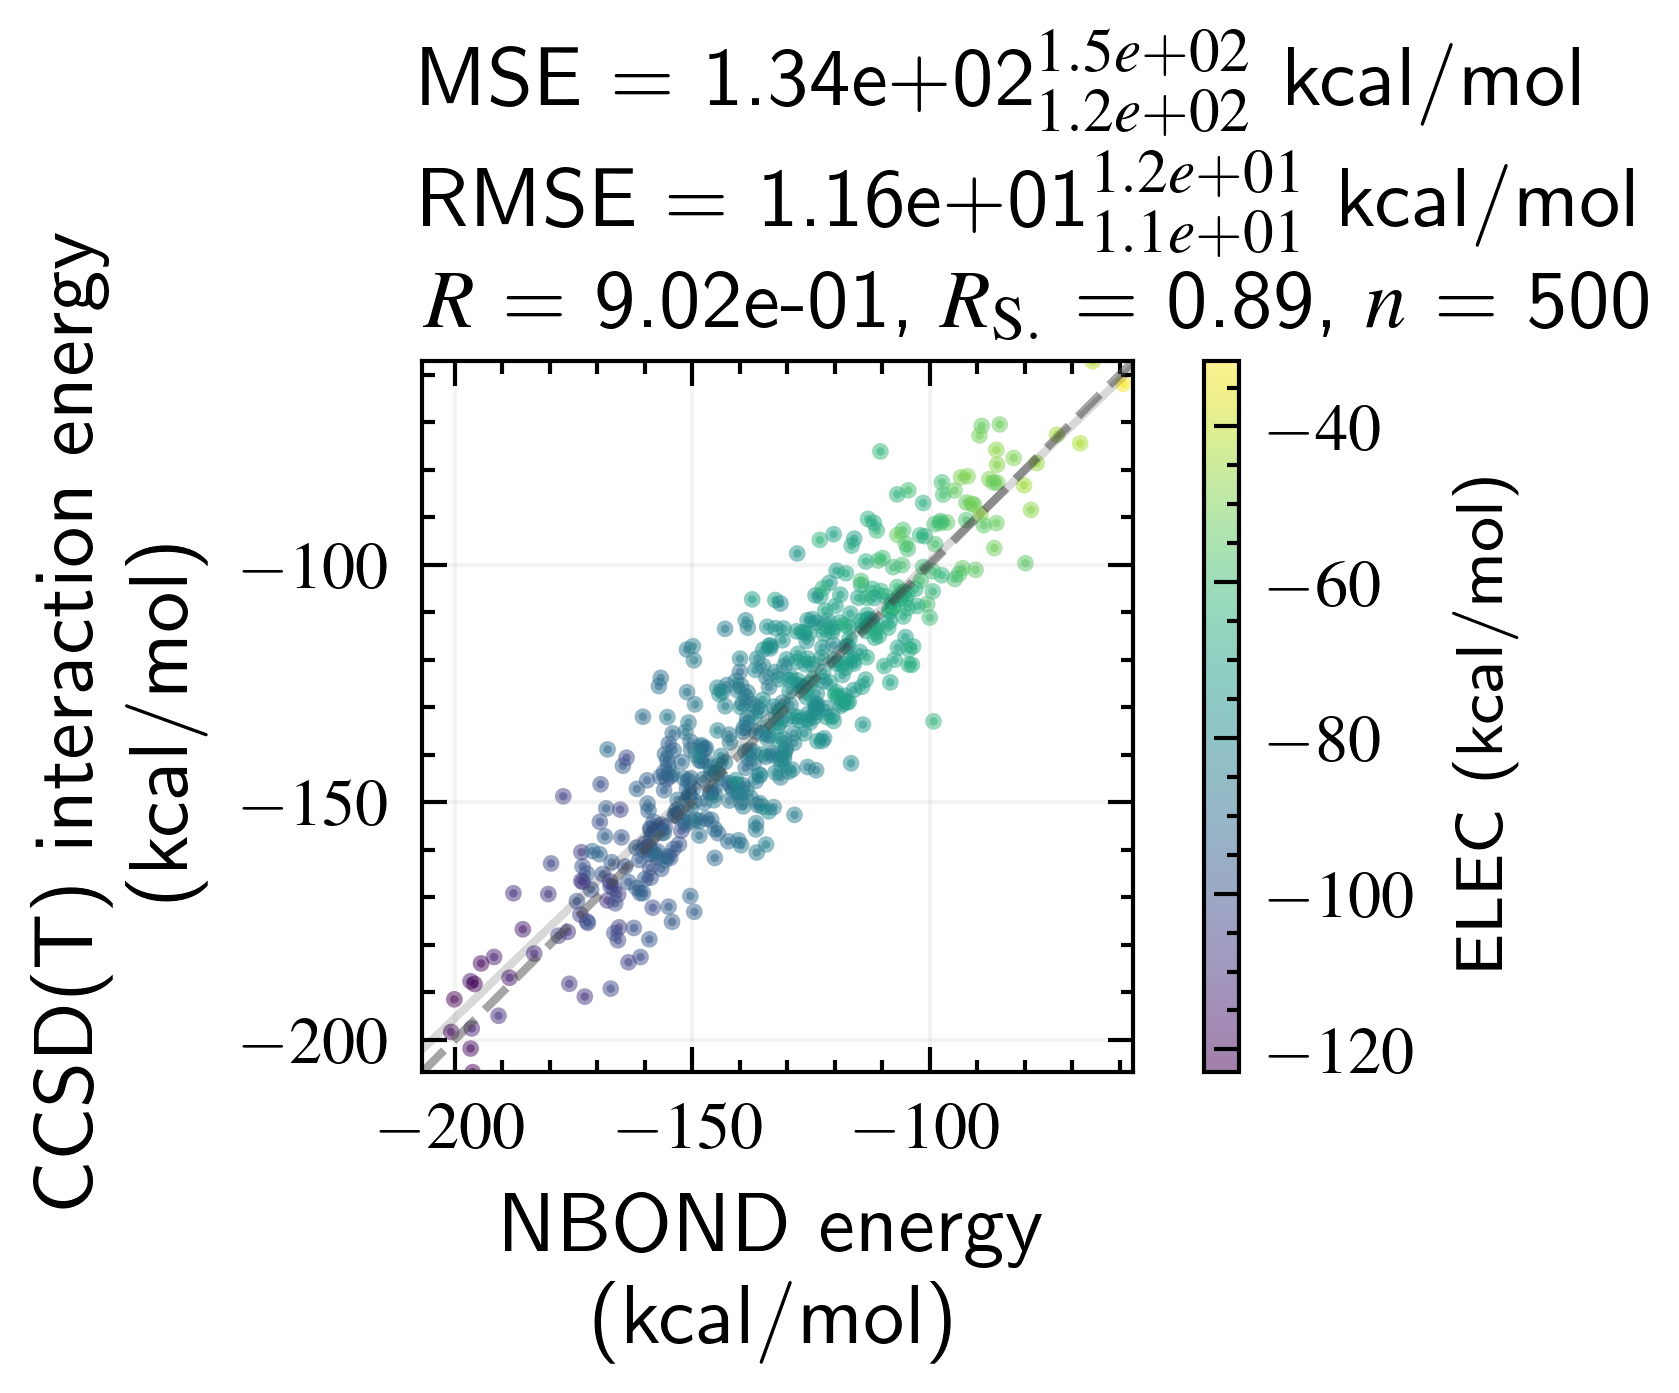

In [11]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC

plot_energy_MSE(_c.data, "ECOL", "fit_ECOL",  elec = "ELEC")



4.56111580439e-312


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 2910.60610280599,
  'RMSE': 53.95003339022127,
  'R': 0.9711142986643587,
  'RS': 0.9681705926823706,
  'n': 500,
  'slope': 0.6036835299777032,
  'intercept': -0.12110096819104399})

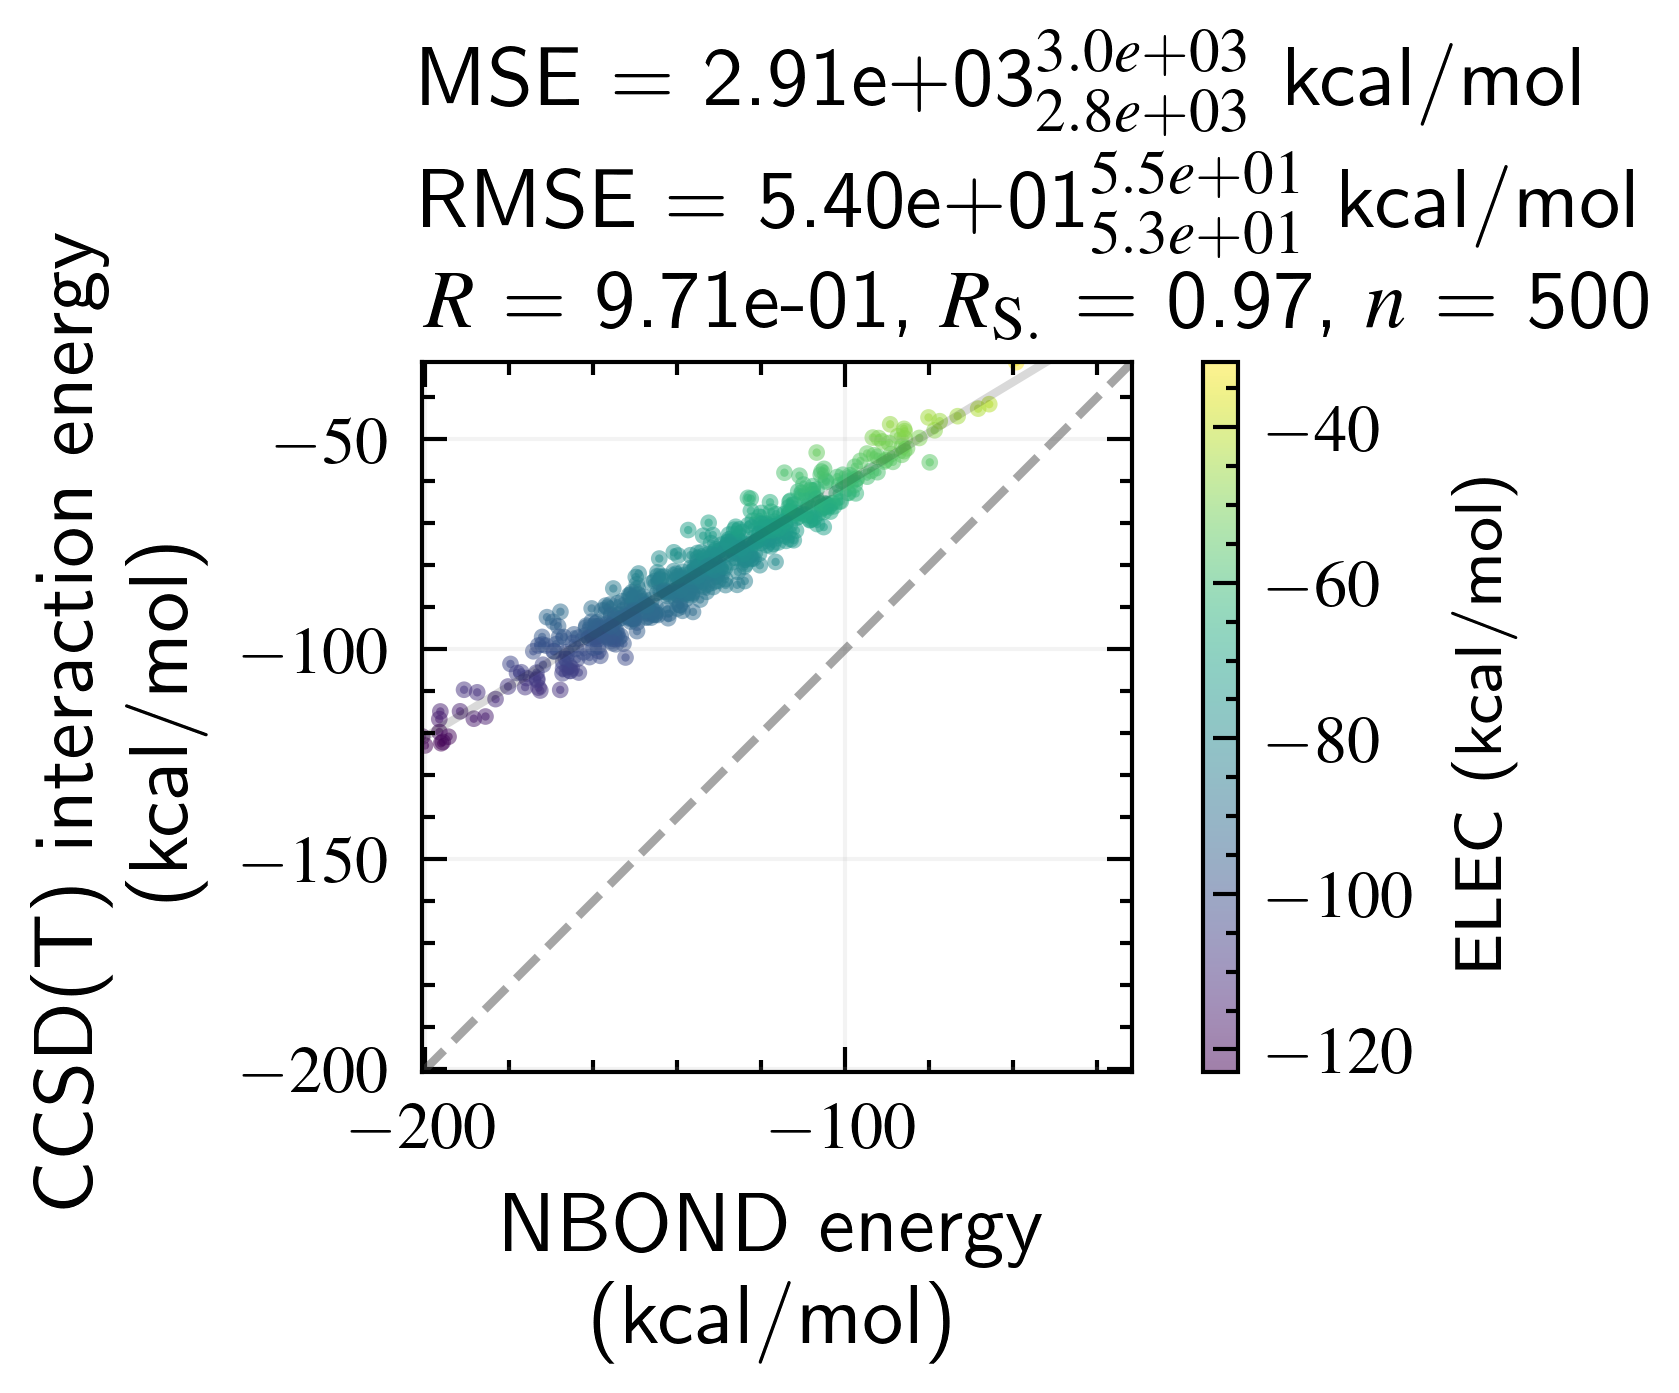

In [12]:
plot_energy_MSE(_c.data, "ECOL", "ELEC",  elec = "ELEC")

In [13]:
pickle_output(_c, "ff/fit_ECOL_mdcm_FOE")

#  LJ fit


In [14]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_mdcm_FOE.pkl"))

In [15]:
LJFF.elec = "fit_ECOL"

In [19]:
fit_repeat(LJFF, 
           11, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [17]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
4,16.345829,313,568,0,True,Optimization terminated successfully.,"[0.5276221063043188, 1.048486957490173, 2.5, 2.5]","([[0.5276221063043188, 1.048486957490173, 2.5,..."
3,16.345831,702,1175,0,True,Optimization terminated successfully.,"[0.5279642142092027, 1.048278461281953, 2.5, 2...","([[0.5279642142092027, 1.048278461281953, 2.5,..."
1,16.345833,436,768,0,True,Optimization terminated successfully.,"[0.5275319937356848, 1.048534895328718, 2.5, 2...","([[0.5275319937356848, 1.048534895328718, 2.5,..."
8,16.345833,602,1027,0,True,Optimization terminated successfully.,"[0.5278557372471002, 1.0483338256991284, 2.5, ...","([[0.5278557372471002, 1.0483338256991284, 2.5..."
2,16.345856,413,729,0,True,Optimization terminated successfully.,"[0.5277846978512446, 1.0483799783593373, 2.5, ...","([[0.5277846978512446, 1.0483799783593373, 2.5..."
5,16.346289,187,380,0,True,Optimization terminated successfully.,"[0.5279137202996088, 1.0483045330436522, 2.499...","([[0.5279137202996088, 1.0483045330436522, 2.4..."
6,16.346849,326,578,0,True,Optimization terminated successfully.,"[0.5276060763944145, 1.0484820391698129, 2.499...","([[0.5276060763944145, 1.0484820391698129, 2.4..."
7,16.347998,310,549,0,True,Optimization terminated successfully.,"[0.5292455108996312, 1.0475346413897062, 2.498...","([[0.5292455108996312, 1.0475346413897062, 2.4..."
11,16.351202,299,537,0,True,Optimization terminated successfully.,"[0.5287075049974166, 1.0480340342790389, 2.499...","([[0.5287075049974166, 1.0480340342790389, 2.4..."
10,24.898771,218,386,0,True,Optimization terminated successfully.,"[0.001, 1.235970877570543, 2.5, 2.499998246769...","([[0.001, 1.235970877570543, 2.5, 2.4999982467..."


In [18]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.042997527826324

#  DE fit


In [20]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
DEFF = next(read_from_pickle(f"ff/fit_ECOL_mdcm_FOE.pkl"))
DEFF.elec = "fit_ECOL"
DEFF

FF: LJ water_cluster fit_ECOL harmonic ECOL (jax_coloumb: True)

In [21]:
fit_repeat(DEFF, 
           10, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [26]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
4,11.775159,1450,2319,0,True,Optimization terminated successfully.,"[0.34101396233481673, 1.2834939106830352, 2.49...","([[0.34101396233481673, 1.2834939106830352, 2...."
1,11.775189,912,1494,0,True,Optimization terminated successfully.,"[0.34104521758863, 1.2834310267899391, 2.49997...","([[0.34104521758863, 1.2834310267899391, 2.499..."
10,11.775450,871,1426,0,True,Optimization terminated successfully.,"[0.3408953323653163, 1.2836243298403414, 2.499...","([[0.3408953323653163, 1.2836243298403414, 2.4..."
9,11.776525,581,981,0,True,Optimization terminated successfully.,"[0.3408284991648972, 1.2836674969253123, 2.5, ...","([[0.3408284991648972, 1.2836674969253123, 2.5..."
3,11.793434,1654,2627,0,True,Optimization terminated successfully.,"[0.339259260364121, 1.2859781218528084, 2.4999...","([[0.339259260364121, 1.2859781218528084, 2.49..."
6,23.471685,655,1085,0,True,Optimization terminated successfully.,"[0.9624434264758188, 0.6530192490987958, 1.195...","([[0.9624434264758188, 0.6530192490987958, 1.1..."
8,28.407072,523,889,0,True,Optimization terminated successfully.,"[0.6263001995250699, 0.9543802137568052, 2.499...","([[0.6263001995250699, 0.9543802137568052, 2.4..."
7,32.821026,546,939,0,True,Optimization terminated successfully.,"[0.9058337244481124, 0.23623405508578757, 1.28...","([[0.9058337244481124, 0.23623405508578757, 1...."
5,35.078831,592,984,0,True,Optimization terminated successfully.,"[0.916481334454034, 0.6876197523860161, 1.5232...","([[0.916481334454034, 0.6876197523860161, 1.52..."
2,45.029907,731,1229,0,True,Optimization terminated successfully.,"[0.6773695728034788, 1.2365348394512246, 1.274...","([[0.6773695728034788, 1.2365348394512246, 1.2..."


In [27]:
# np.sqrt(10.7)

In [28]:
list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").x)[0]

array([ 0.34101396,  1.28349391,  2.49999935,  2.49999954,  7.40267606,
       19.17126787])

In [29]:
best = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

3.43149513800342